# 链接仪器

In [1]:
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt
import numpy as np, sympy as sy
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys, imp, pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.cluster import KMeans
from qulab.wavepoint import WAVE_FORM as WF
from qulab import optimize, measureroutine, computewave, imatrix, waveform_new, measureroutine_new
from qulab.optimize import Collect_Waveform 
from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian
from qulab.math.qst import transformList, acquireVFromData, vToRho
op = imp.reload(optimize)
mr = imp.reload(measureroutine)
cw = imp.reload(computewave)
mx = imp.reload(imatrix)
wn = imp.reload(waveform_new)
mn = imp.reload(measureroutine_new)

In [2]:
awg131 = await connect('AWG131')
awg132 = await connect('AWG132')
awg133 = await connect('AWG133')
awg134 = await connect('AWG134')
# #awg135 = await connect('AWG135')
awg100 = await connect('AWG100')
ats18 = await connect('ATS18')
#ats19 = await connect('ATS19')
psg101 = await connect('PSG101')
psg230 = await connect('PSG230')
psg104 = await connect('PSG104')
psg103 = await connect('PSG103')
psg105 = await connect('PSG105')
psg106 = await connect('PSG106')
dc01 = await connect('DC01')
dc02 = await connect('DC02')
dc03 = await connect('DC03')
dc04 = await connect('DC04')
dc05 = await connect('DC05')
dc06 = await connect('DC06')
dc07 = await connect('DC07')
dc08 = await connect('DC08')
dc10 = await connect('DC10')
dc11 = await connect('DC11')
dc15 = await connect('DC15')
dc20 = await connect('DC20')
# # #pna = await connect('PNA')

In [35]:
await psg103.setValue('Frequency',2.5e9)

# qubit工作点

In [3]:
f_cavity = np.array([6.505,6.517,6.53,6.544,6.559,6.574,6.587,6.601,6.607,6.63])*1e9
f_cavity = {'q%d'%(i):j for i, j in enumerate(f_cavity,start=1)}
atributte = ['q_name','inst','T_bias','specfunc','bias','zpulse','f_lo','delta','f_ex','delta_ex',\
             'power_ex','power_rabi','pi_len','T1','state']
qubit = namedtuple('qubit',atributte,defaults=[None]*len(atributte))

jpa = qubit(q_name='jpa',inst={'dc':'dc03','pump':'psg_pump'},bias=0.067,f_ex=2*6.3e9+2e6,power_ex=-1.767) #power=-2.1

## 保存工作点

In [56]:
qstate = []
def tuple2dict(q):
    for i in q:
        qstate.append(i._asdict())
    return qstate

bit = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
filepath = save('QubitState','qubitstate',state = tuple2dict(bit),base_path=r'D:\skzhao\file_name')
with open(r'D:\skzhao\file_name\file_name.txt', mode='a') as filename:
    filename.write(str(filepath))
    filename.write('\n')
print(filepath)

D:\skzhao\file_name\2020\0331\QubitState\qubitstate_20200331220551.npz


## 提取工作点

In [4]:
fl = np.loadtxt(r'D:\skzhao\file_name\file_name.txt',dtype='str')
f = str(fl[-1])
data = np.load(f,allow_pickle=True)
def dict2tuple(q):
    bit = []
    for i,k in enumerate(q):
        attr = []
        for j in atributte:
            if j in k:
                attr.append(k[j])
            else:
                attr.append(None)
        globals()['q%d'%(i+1)] = qubit(*attr)

dict2tuple(data['state'])
print(f)

D:\skzhao\file_name\2020\0331\QubitState\qubitstate_20200331220551.npz


# 指定仪器

In [5]:
psg_lo = psg104
psg_ex1 = psg105
psg_ex2 = psg106
psg_ex3 = psg230
psg_pump = psg101
psg = {'psg_lo':psg_lo,'psg_ex1':psg_ex1,'psg_ex2':psg_ex2,'psg_ex3':psg_ex3,'psg_pump':psg_pump}
ats = ats18
awg_trig = awg100
dc = {'dc01':dc01,'dc02':dc02,'dc03':dc03,'dc05':dc05,'dc06':dc06,\
      'dc07':dc07,'dc08':dc08,'dc10':dc10,'dc11':dc11,'dc15':dc15,'dc20':dc20}
#awg = awg132
awg_list = {'awg131':awg131,'awg132':awg132,'awg133':awg133,'awg134':awg134,'awgread':awg133}

## 测量类

In [6]:
measure = mr.common(f_cavity,ats,dc,psg,awg_list,jpa)

In [91]:
await mr.awgSync(measure)

# 信号检查

In [8]:
await mr.modulation_read(measure,np.array([50e6]),tdelay=1500)
await mr.ats_setup(ats,np.array([50e6]),l=1500)
await awg133.run()
f_list = await ats.getValue('f_list')
f_list

array([50000000.])

In [7]:
await ats.getValue('n')

1024

## 复平面信号

<IPython.core.display.Javascript object>


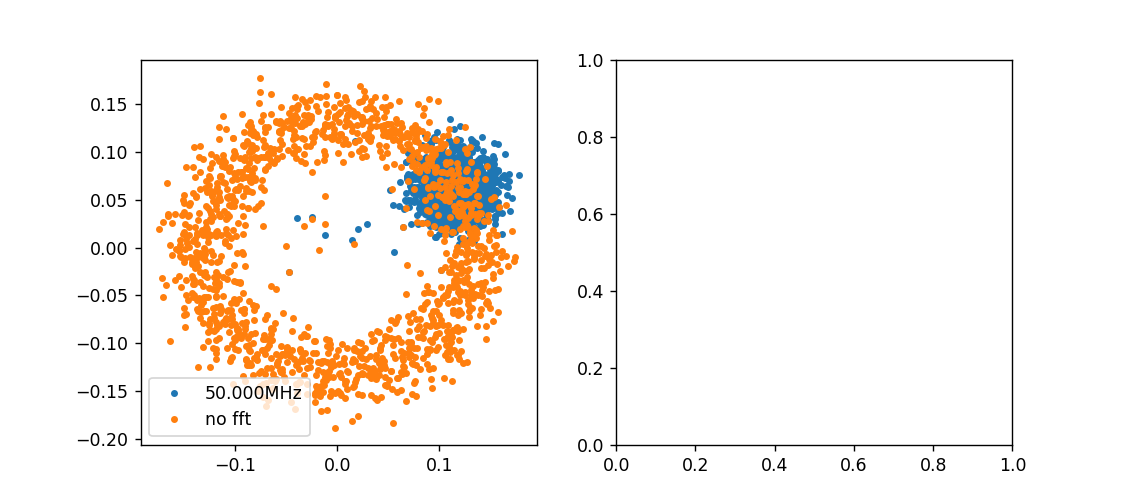

In [12]:

I, Q = 0, 0
await psg_lo.setValue('Output','ON')
f_list = np.array(await ats.getValue('f_list'))
for i in range(1):
    chA, chB = await ats.getTraces(fft=False,avg=True,hilbert=True,is2ch=True,offset=True)
    I += chA
    Q += chB
s, e, h = (I+1j*Q), [], len(f_list)//2+len(f_list)%2
t = np.arange(0, len(s), 1) / 1e9

fig, axes = plt.subplots(ncols=2,nrows=h,figsize=(9,4*h))
for i,f in enumerate(f_list):
    em = np.exp(-1j * 2 * np.pi * f * t)
    e.append(em)
    if h == 1:
        axes[i].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i].legend(loc="lower left")
    else:
        axes[i//2][i%2].plot(np.real(s*em),np.imag(s*em),'.',label='%.3fMHz'%(f/1e6))
        axes[i//2][i%2].plot(np.real(s),np.imag(s),'.',label='no fft')
        axes[i//2][i%2].legend(loc="lower left")

plt.show()

## 时域信号

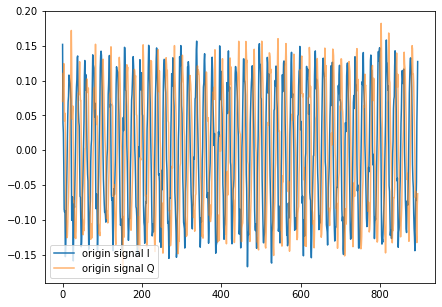

In [446]:
# %matplotlib notebook
I, Q = 0, 0
await psg['psg_lo'].setValue('Output','ON')
await psg['psg_ex2'].setValue('Output','OFF')
for i in range(1):
    chA, chB = await ats.getTraces()
    I += chA
    Q += chB
    
plt.figure(figsize=(7,5))
plt.plot(np.arange(len(I)), I,label='origin signal I')
plt.plot(np.arange(len(Q)), Q,label='origin signal Q',alpha=0.6)
#plt.plot(np.arange(len(Q)), np.sqrt(I**2+Q**2),'.',label='envelop')
plt.legend(loc="lower left")
plt.show()

## 频域信号

<IPython.core.display.Javascript object>


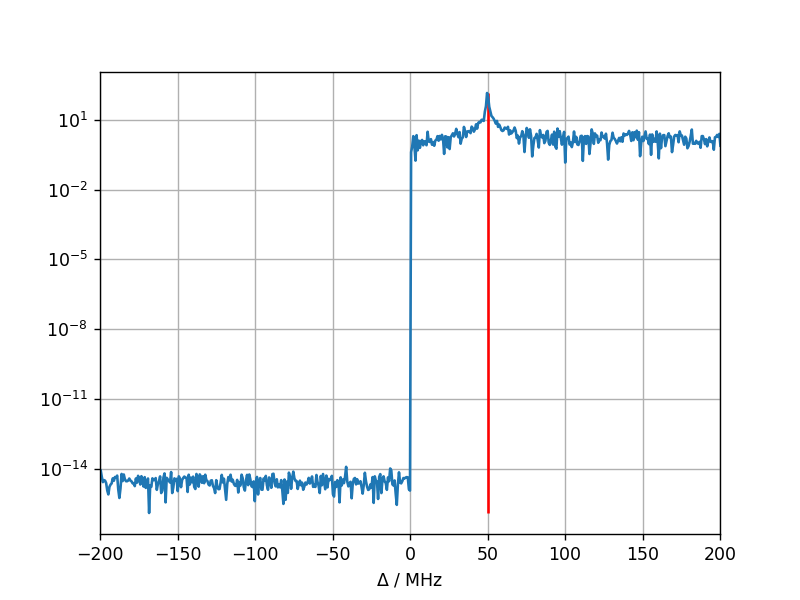

In [14]:
x = np.fft.fftshift(np.fft.fftfreq(len(I)))*1.e9
y = np.fft.fftshift(np.fft.fft(I + 1j*Q))
Delta_list = np.array(await ats.getValue('f_list'))
plt.figure()

plt.vlines(Delta_list/1e6, np.min(np.abs(y)), np.max(np.abs(y)), 'r')

plt.semilogy(x/1e6, np.abs(y))

plt.grid(which='both')
plt.xlabel(r'$\Delta$ / MHz')
plt.xlim(-200,200)
plt.show()

# 仪器状态

In [7]:
await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=['awg131','awg132','awg133','awg134'])

In [27]:
state = await mr.QueryInst(measure)
pd.DataFrame(state)

,dc01,dc02,dc03,dc05,dc06,dc07,dc08,dc10,dc11,dc15,dc20,psg_lo,psg_ex1,psg_ex2,psg_ex3,psg_pump
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.636660GHz,3.746000GHz,3.827000GHz,4.000000GHz,12.602000GHz
load,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,high Z,NaN,NaN,NaN,NaN,NaN
mform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXT,EXT,EXT,EXT,INT
moutput,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,0
offset,0,0.5845,0.067,0,0,1.0325,-0.3,0,0,0,0,NaN,NaN,NaN,NaN,NaN
output,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0,1
power,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.000000dBm,-6.000000dBm,15.000000dBm,10.000000dBm,-1.770000dBm


In [82]:
await mr.RecoverInst(measure)

In [47]:
await mr.jpa_switch(measure,'ON')

In [26]:
await psg_ex2.setValue('Power',15)

# S21

In [125]:
qubits = mr.qubitCollections([q1,q2,q3,q4,q5,q6,q7,q8,q9,q10])

com7 open...
DS Instruments,DAT64H,410,V9.07
last ATT 13.0
now ATT 13.0


Output()

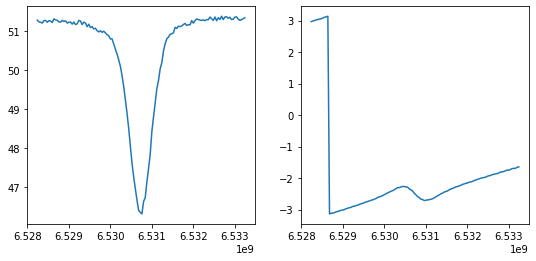

In [12]:
q_target = q3
tag = q_target.q_name
att_setup = mr.Att_Setup('com7')
att_setup.Att(13)
#await psg[q_target.inst['ex_lo']].setValue('Output','OFF')
await mr.jpa_switch(measure,state='ON')
job = Job(mr.S21, (q_target,measure,True), tags=[tag], max=126)
f_s21, s_s21 = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,20*np.log10(np.abs(s_s21)))
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

# S21vsFlux

In [75]:
current = np.linspace(-2,2,21)
bits = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
#await dc[bis[0].inst['dc']].DC(1)
for i in bits:
    tag = i.q_name
    print(tag)
    await mr.jpa_switch(measure,'ON')
    await awg134.output_on(ch=7)
    await awg134.output_on(ch=8)
    qubits = mr.qubitCollections(bits,q_target=i.q_name)
    await psg[i.inst['ex_lo']].setValue('Output','OFF')
    job = Job(mr.S21vsFlux, (qubits,measure,current,True), tags=[tag], max=len(current))
    v_bias, f_bias, s_bias = await job.done()
    await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)

q1


Output()

q2


Output()

q3


Output()

q4


Output()

q5


Output()

q6


Output()

q7


Output()

q8


Output()

q9


Output()

q10


Output()

# S21vsPower

In [26]:
qubits = mr.qubitCollections([q1,q2,q3,q4,q5,q6,q7,q8,q9,q10])

Output()

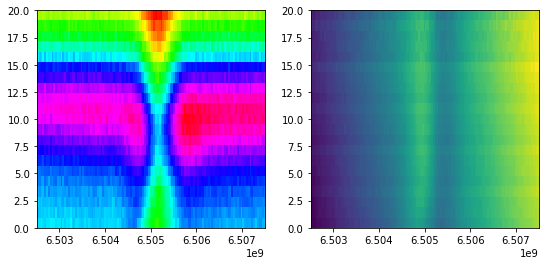

In [27]:
q_target, att = qubits, np.linspace(0,20,21)
tag = q_target.q_name
#await psg[q_target.inst['ex_lo']].setValue('Output','OFF')
job = Job(mr.S21vsPower, (q_target,measure,att,'com7'), tags=[tag], max=len(att))
att_p, f_p, s_p = await job.done()
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
extent = [np.min(f_p[0][:,0]),np.max(f_p[0][:,0]),np.min(att_p[:,0]),np.max(att_p[:,0])]
axes[0].imshow(np.abs(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto',cmap='hsv')
axes[1].imshow(np.angle(s_p[:,:,0]),extent=extent,origin='lower',aspect='auto')
plt.show()

# singlespce

In [21]:
await dc[q3.inst['dc']].DC((q3.T_bias[0]/2+q3.T_bias[1]))
await dc[q5.inst['dc']].DC((q5.T_bias[0]/2+q5.T_bias[1]))
# await dc[q1.inst['dc']].DC((q1.T_bias[0]/2+q1.T_bias[1]))
# await dc[q5.inst['dc']].DC((q5.T_bias[0]/2+q5.T_bias[1]))

x = sy.Symbol('x')
q_target = q4
att_single, bias = q_target.power_ex, -0.104
#f_com = 3.736
f_com = np.float(q_target.specfunc.evalf(subs={x:bias}))
# await mr.RecoverInst(measure,state=q_target.state[0])
round(f_com,3)

3.698

com8 open...
DS Instruments,DAT64H,391,V9.10
last ATT 30.0
now ATT 30.0


Output()

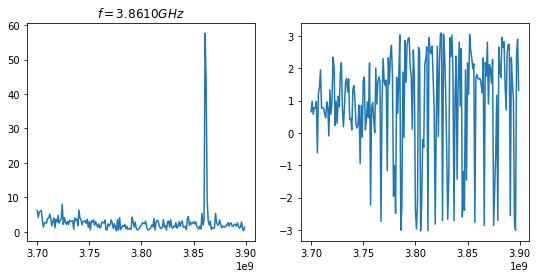

In [22]:
tag, freq = q_target.q_name, np.arange(-100,101,1)*1e6+round(f_com,3)*1e9
freq = np.arange(3.7,3.9,0.001)*1e9
await psg_ex2.setValue('Power',15)
await dc[q_target.inst['dc']].DC(bias)
att_setup = mr.Att_Setup(q_target.inst['com'])
att_setup.Att(q_target.power_ex)
#await psg[q_target.inst['ex_lo']].setValue('Power',0)
await mr.modulation_ex(q_target,measure)
await psg_ex1.setValue('Moutput','ON')
#await psg_ex1.setValue('Output','OFF')
await mr.jpa_switch(measure,'ON')
job = Job(mr.singlespec, (q_target,measure,freq,True), tags=[tag], max=len(freq))
f_ss, s_ss = await job.done()
state = await mr.QueryInst(measure)
index = np.abs(s_ss).argmax(axis=0)
f_rabi = np.array([f_ss[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_ss,np.abs(s_ss))
axes[0].set_title('$f=%.4fGHz$'%(f_rabi[0]/1e9))
axes[1].plot(f_ss,np.angle(s_ss))
plt.show()

In [23]:
q4 = q4._replace(bias=bias,f_ex=f_rabi,f_lo=(measure.f_lo-measure.delta),state=[state,measure.delta,measure.base,measure.readlen])

In [276]:
q3 = q3._replace(inst={'dc': 'dc06', 'z_awg': 'awg131', 'z_ch': 3, 'ex_awg': 'awg133', 'ex_ch': [3, 4], 'ex_lo': 'psg_ex1', 'com': 'com12'},delta_ex=np.array([80e6]),power_ex=60)

In [17]:
q4.bias

-0.102

In [18]:
q4.f_ex

array([3.863e+09])

In [54]:
q7.state

[{'dc01': {'offset': 0.0, 'load': 'high Z'},
  'dc02': {'offset': 0.5845, 'load': 'high Z'},
  'dc03': {'offset': 0.067, 'load': 'high Z'},
  'dc05': {'offset': 0.0, 'load': 'high Z'},
  'dc06': {'offset': 0.0, 'load': 'high Z'},
  'dc07': {'offset': 1.0325, 'load': 'high Z'},
  'dc08': {'offset': -0.3, 'load': 'high Z'},
  'dc10': {'offset': 0.0, 'load': 'high Z'},
  'dc11': {'offset': 0.0, 'load': 'high Z'},
  'dc15': {'offset': 0.0, 'load': 'high Z'},
  'dc20': {'offset': 0.0, 'load': 'high Z'},
  'psg_lo': {'freq': '6.636640GHz',
   'power': '13.000000dBm',
   'output': '1',
   'moutput': '0',
   'mform': 'EXT'},
  'psg_ex1': {'freq': '3.746000GHz',
   'power': '-6.000000dBm',
   'output': '0',
   'moutput': '1',
   'mform': 'EXT'},
  'psg_ex2': {'freq': '3.899000GHz',
   'power': '15.000000dBm',
   'output': '1',
   'moutput': '1',
   'mform': 'EXT'},
  'psg_ex3': {'freq': '4.000000GHz',
   'power': '10.000000dBm',
   'output': '0',
   'moutput': '0',
   'mform': 'EXT'},
  'psg_pu

## 单条谱扫电压

com8 open...
DS Instruments,DAT64H,391,V9.10
last ATT 30.0
now ATT 30.0


Output()

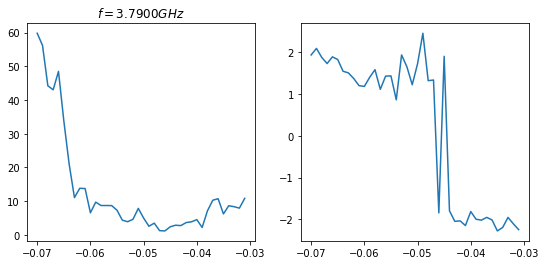

In [48]:
tag, ftarget, biaslist = q_target.q_name, 3.75e9, np.arange(-0.02,0.02,0.001) + bias

att_setup = mr.Att_Setup(q_target.inst['com'])
att_setup.Att(q_target.power_ex)
await mr.modulation_ex(q_target,measure)
await psg_ex1.setValue('Moutput','ON')
await mr.jpa_switch(measure,'ON')
job = Job(mr.specbias, (q_target,measure,ftarget,biaslist,True), tags=[tag], max=len(biaslist))
v_sb, s_sb = await job.done()
index = np.abs(s_sb).argmax(axis=0)
v_rabi = np.array([v_sb[:,i][j] for i, j in enumerate(index)])
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(v_sb,np.abs(s_sb))
axes[0].set_title('$f=%.4fGHz$'%(f_rabi[0]/1e9))
axes[1].plot(v_sb,np.angle(s_sb))
plt.show()

# Rabi

In [30]:
q_target = q7
if q_target.inst['ex_lo'] == 'psg_ex2':
    t_rabi = np.linspace(5,256,201)
    att_single = 13
else:
    t_rabi = np.linspace(1,201,201)
    att_single = 23
await measure.awg['awgread'].stop()
await measure.awg['awgread'].query('*OPC?')
await measure.awg['awgread'].remove_sequence(name='Read')
await measure.awg[q_target.inst['ex_awg']].remove_sequence(name=''.join((q_target.inst['ex_awg'],'coherence')))
measure.wave['Read'] = [['Readout_I']*len(t_rabi),['Readout_Q']*len(t_rabi)]
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
# # await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])

com8 open...
DS Instruments,DAT64H,391,V9.10
last ATT 30.0
now ATT 13.0


Output()

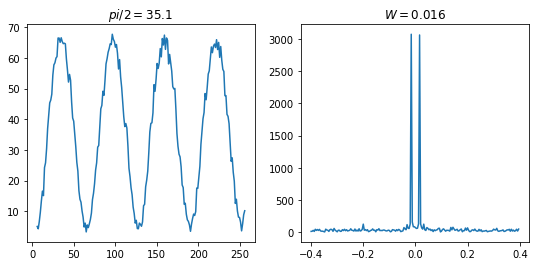

In [20]:
tag = q_target.q_name
att_setup = mr.Att_Setup(q_target.inst['com'])
att_setup.Att(att_single)
#await dc[q_target.inst['dc']].DC(bias)
await psg_ex1.setValue('Moutput','ON')
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await psg['psg_lo'].setValue('Output','ON')
await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.rabi, (q_target,measure,t_rabi,(len(t_rabi)-1),True), tags=[tag], max=500,avg=True)
t_r, s_r = await job.done()
state = await mr.QueryInst(measure)
index = np.abs(s_r).argmax(axis=0)
t_op = np.array([t_r[:,i][j] for i, j in enumerate(index)])
t_op = op.RowToRipe().firstMax(t_r[:,0],np.abs(s_r[:,0]),num=0)
sample = (np.max(t_r[:,0]) - np.min(t_r[:,0]))/(len(t_r[:,0]) - 1)
yt  = np.fft.fftshift(np.fft.fftfreq(len(s_r[:,0]))) / sample
amp = np.fft.fftshift(np.fft.fft(s_r[:,0]))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_r,np.abs(s_r))
axes[0].set_title('$pi/2=%.1f$'%t_op)
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
axes[1].set_title('$W=%.3f$'%(np.abs(yt[yt!=0][np.argmax(np.abs(amp[yt!=0]))])))
plt.show()

In [14]:
index = np.abs(s_r).argmax(axis=0)
t_op = np.array([t_r[:,i][j] for i, j in enumerate(index)])
t_op

array([29.])

In [21]:
q7 = q7._replace(pi_len=t_op,power_rabi=att_single,state=[state,measure.delta,measure.base,measure.readlen])

In [431]:
q3

qubit(q_name='q3', inst={'dc': 'dc06', 'z_awg': 'awg131', 'z_ch': 3, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex2', 'com': 'com8'}, T_bias=[1.759, 0.224], specfunc=0.131407814121408 - 3.8786690306747*cos(0.434829499349968*pi*x + 2.8383237533104), bias=-0.05, zpulse=None, f_lo=array([6.53064e+09]), delta=array([50000000.]), f_ex=array([3.744e+09]), delta_ex=array([0]), power_ex=30, power_rabi=10, pi_len=23.12, T1=23016.178849233776, state=[{'dc01': {'offset': 0.0, 'load': 'high Z'}, 'dc02': {'offset': 0.0, 'load': 'high Z'}, 'dc03': {'offset': 0.067, 'load': 'high Z'}, 'dc05': {'offset': 0.0, 'load': 'high Z'}, 'dc06': {'offset': -0.05, 'load': 'high Z'}, 'dc07': {'offset': 0.0, 'load': 'high Z'}, 'dc08': {'offset': 0.0, 'load': 'high Z'}, 'dc10': {'offset': 0.0, 'load': 'high Z'}, 'dc11': {'offset': 0.0, 'load': 'high Z'}, 'dc15': {'offset': 0.0, 'load': 'high Z'}, 'dc20': {'offset': 0.0, 'load': 'high Z'}, 'psg_lo': {'freq': '6.580640GHz', 'power': '13.000000dBm', 'output': 

# rabiPower

com8 open...
DS Instruments,DAT64H,391,V9.10
last ATT 45.0
now ATT 05.0


Output()

C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


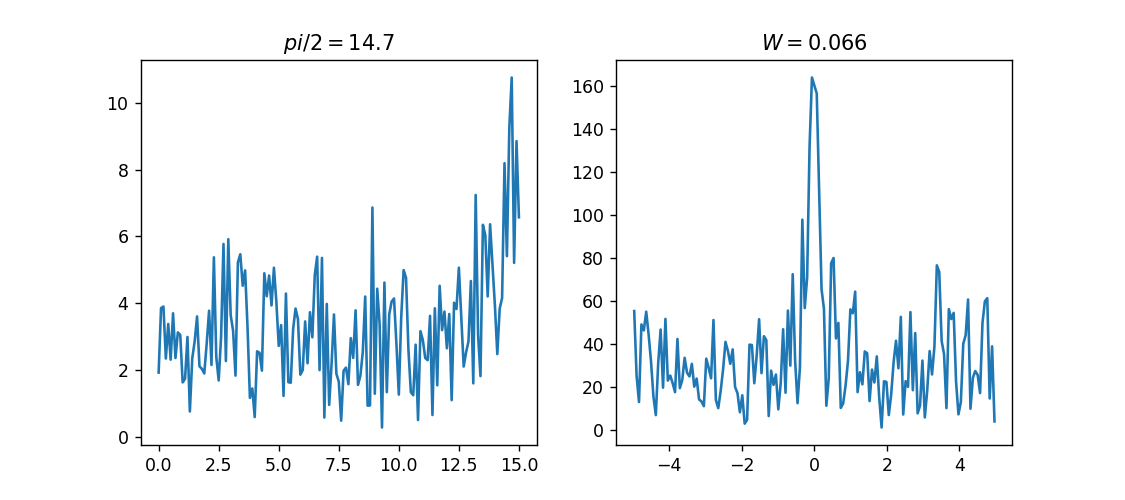

In [270]:
att, q_target = np.linspace(0,15,151), q3

mr.Att_Setup(q_target.inst['com']).Att(5)
await psg_ex1.setValue('Moutput','ON')
await psg[q_target.inst['ex_lo']].setValue('Output','ON')
await mr.jpa_switch(measure,'ON')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
job = Job(mr.rabiPower, (q_target,measure,att), tags=[tag], max=len(att))
t_r, s_r = await job.done()
state = await mr.QueryInst(measure)
index = np.abs(s_r).argmax(axis=0)
t_op = np.array([t_r[:,i][j] for i, j in enumerate(index)])
t_op = op.RowToRipe().firstMax(t_r[:,0],np.abs(s_r[:,0]),num=0)
sample = (np.max(t_r[:,0]) - np.min(t_r[:,0]))/(len(t_r[:,0]) - 1)
yt  = np.fft.fftshift(np.fft.fftfreq(len(s_r[:,0]))) / sample
amp = np.fft.fftshift(np.fft.fft(s_r[:,0]))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_r,np.abs(s_r))
axes[0].set_title('$pi/2=%.1f$'%t_op)
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
axes[1].set_title('$W=%.3f$'%(np.abs(yt[yt!=0][np.argmax(np.abs(amp[yt!=0]))])))
plt.show()

In [254]:
q3 = q3._replace(pi_len=20,power_rabi=t_op,state=[state,measure.delta,measure.base,measure.readlen])

# Readout point

Output()

<IPython.core.display.Javascript object>


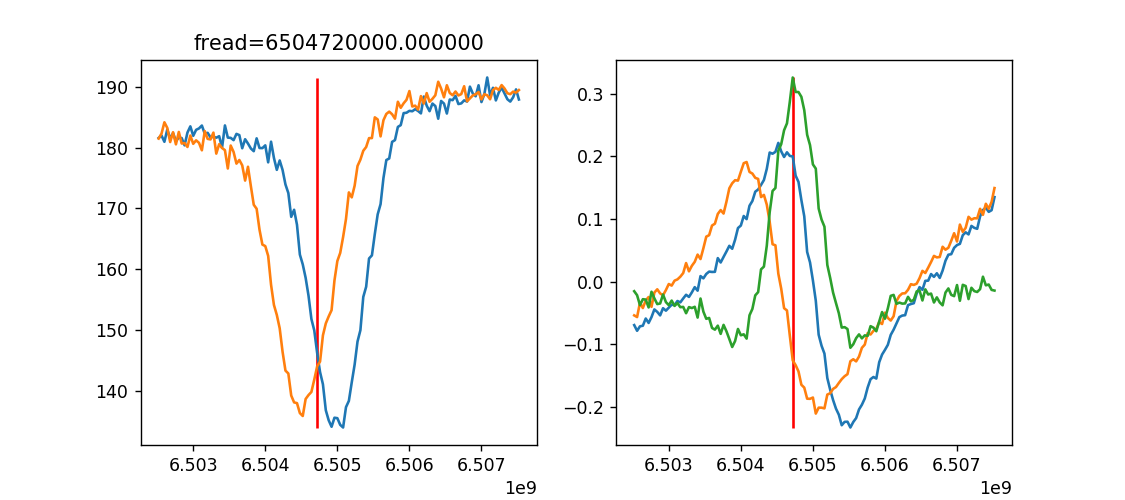

In [33]:
q_target = q1
job = Job(mr.readOp, (q_target,measure,True), tags=[tag], max=2)
st, f_op, s_op = await job.done()
f, s_off, s_on = f_op[:,:,0][0], s_op[:,:,0][0], s_op[:,:,0][1]
x_off, y_off = op.RowToRipe().deductPhase(f,s_off)
x_on, y_on = op.RowToRipe().deductPhase(f,s_on)
anglediff = (np.angle(y_off[0])-np.angle(y_on[0]))
index = np.abs(anglediff).argmax(axis=0)
#index = np.abs(s_off).argmin(axis=0)
f_lo = f[index]
measure.f_lo = np.array([f_lo])
await psg['psg_lo'].setValue('Frequency',(f_lo+measure.delta[0]))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_op[:,:,0].T,np.abs(s_op[:,:,0].T))
axes[0].set_title('fread=%f'%f_lo)
axes[0].vlines(f_lo,np.max(np.abs(s_op[:,:,0].T)),np.min(np.abs(s_op[:,:,0].T)),'r')
axes[1].plot(x_off,np.angle(y_off[0]))
axes[1].plot(x_on,np.angle(y_on[0]))
axes[1].plot(x_off,anglediff)
axes[1].vlines(f_lo,np.max(anglediff),np.min(np.angle(y_off[0])),'r')
plt.show()

# 优化读出长度

In [145]:
await measure.psg['psg_lo'].setValue('Power',13)
att_setup = mr.Att_Setup('com7')
att_setup.Att(9)
job = Job(mr.readWavelen, (q_target,measure), tags=[tag], max=21)
wl, s_wl = await job.done()
# s_off, s_on = s_st[0][:,0], s_st[1][:,0]
# plt.figure()
# plt.plot(np.real(s_off),np.imag(s_off),'.')
# plt.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
# plt.axis('equal')
# plt.show()

com7 open...
DS Instruments,DAT64H,410,V9.07
ATT 09.0


Output()

<IPython.core.display.Javascript object>


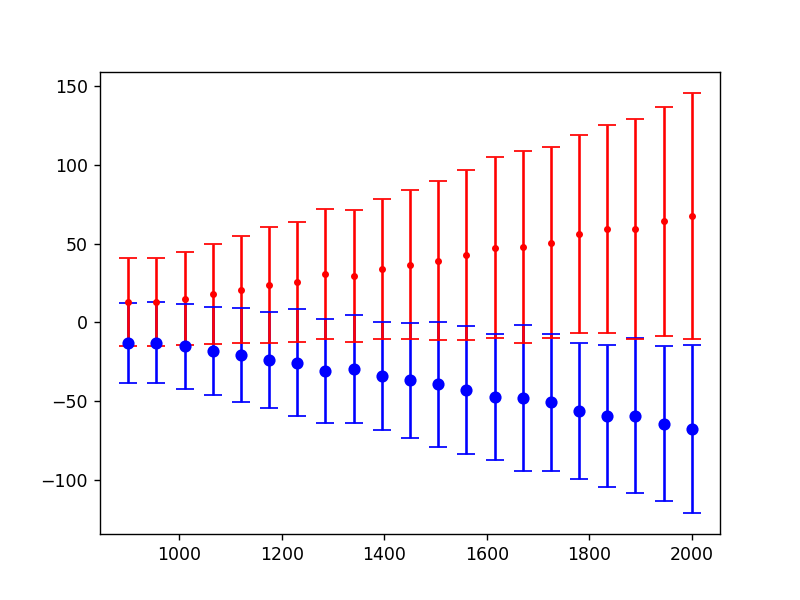

In [151]:
y = [s_wl[i,0,1] for i in range(21)]
s_std = [s_wl[i,0,2] for i in range(21)]
x = [s_wl[i,1,1] for i in range(21)]
s_offstd = [s_wl[i,1,2] for i in range(21)]
add, diff = (np.array(x)+np.array(y))/2, np.array(x)-np.array(y)
s_off, s_on = (np.array(x)-add)/np.exp(1j*np.angle(diff)), (np.array(y)-add)/np.exp(1j*np.angle(diff))
plt.figure()
plt.errorbar(wl,np.real(s_on),yerr=np.abs(s_std),fmt='bo',capsize=5)
plt.errorbar(wl,np.real(s_off),yerr=np.abs(s_offstd),fmt='r.',capsize=5)
plt.show()

# 临界线

com7 open...
DS Instruments,DAT64H,410,V9.07
ATT 09.0


Output()

<IPython.core.display.Javascript object>


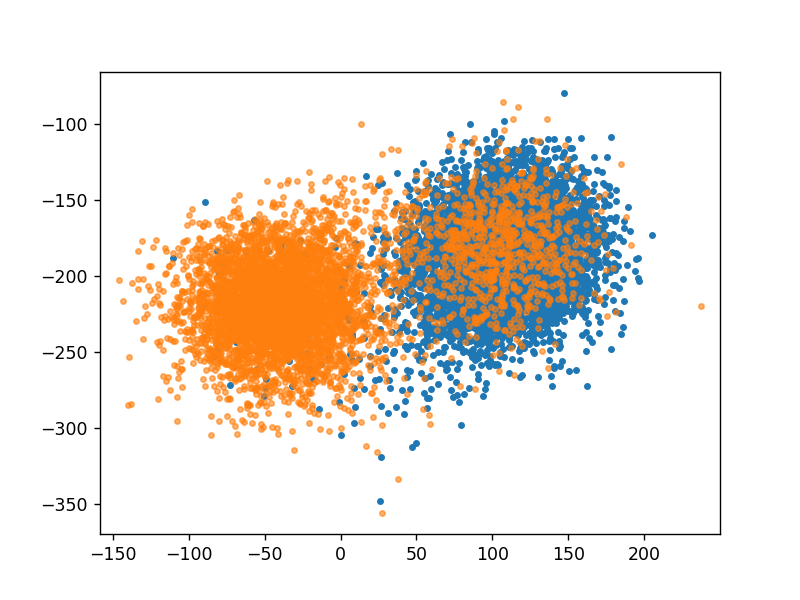

In [79]:
await measure.psg['psg_lo'].setValue('Power',13)
att_setup = mr.Att_Setup('com7')
att_setup.Att(9)
job = Job(mr.threshHold, (q_target,measure), tags=[tag], max=2)
st, s_st = await job.done()
s_off, s_on = s_st[0][:,0], s_st[1][:,0]
plt.figure()
plt.plot(np.real(s_off),np.imag(s_off),'.')
plt.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
plt.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


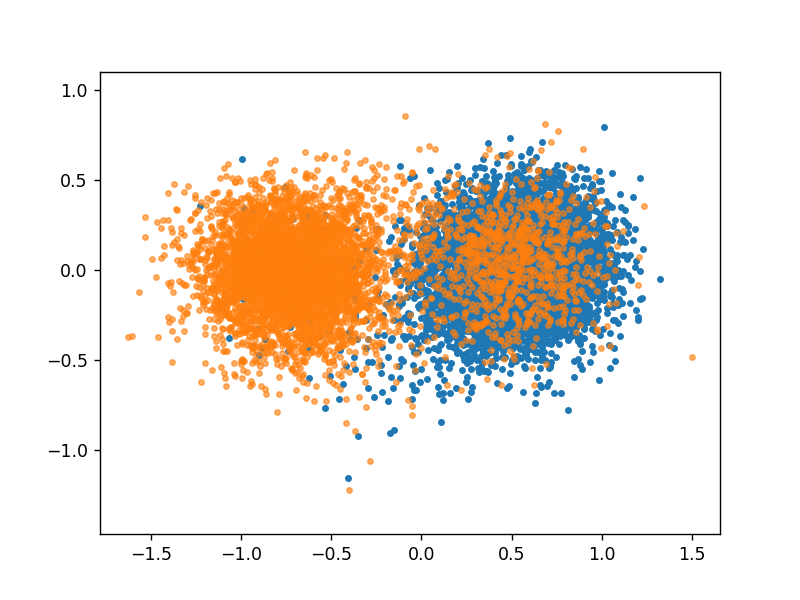

In [80]:
x, y = s_st[0][:,0], s_st[1][:,0]
add, diff = (np.mean(x)+np.mean(y))/2, np.mean(x)-np.mean(y)
s_off, s_on = (x-add)/diff, (y-add)/diff
plt.figure()
plt.plot(np.real(s_off),np.imag(s_off),'.')
plt.plot(np.real(s_on),np.imag(s_on),'.',alpha=0.6)
plt.axis('equal')
plt.show()

0.45243275316455694


<IPython.core.display.Javascript object>


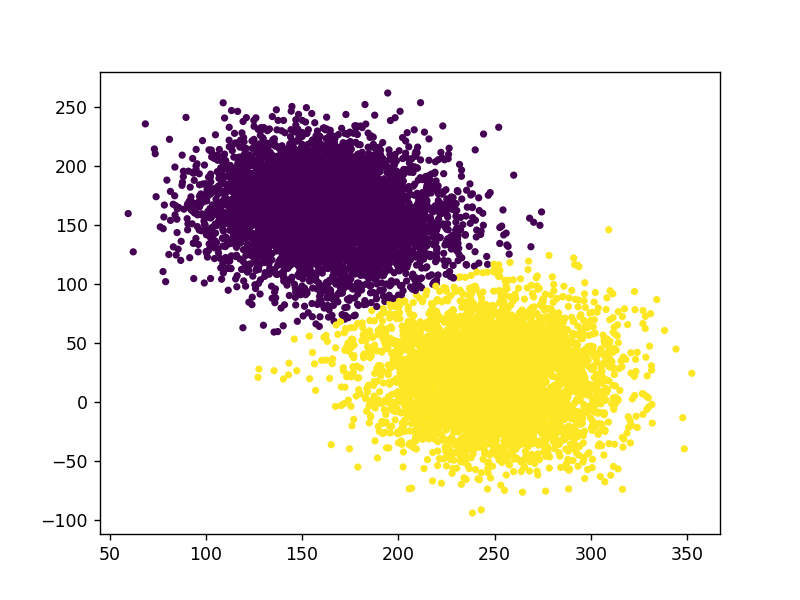

In [380]:
S = list(s_off) + list(s_on)
S = np.array(S)
x,z = np.real(S), np.imag(S)
d = list(zip(x,z))
d = np.mat(d)
kmeans = KMeans(n_clusters=2,max_iter=100,tol=0.001)
kmeans.fit(d)
measure.predict = kmeans.predict
y = kmeans.predict(d)
print(list(y).count(1)/len(y))
plt.figure()
plt.scatter(x,z,c=y,s=10)
plt.show()

0.9816060126582279


<IPython.core.display.Javascript object>


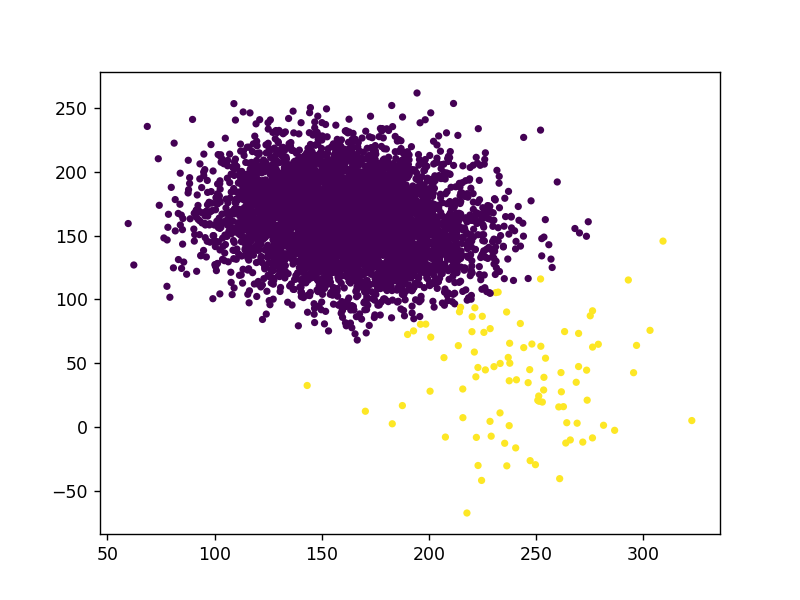

In [381]:
d = list(zip(np.real(s_off),np.imag(s_off)))
y = measure.predict(d)
print(list(y).count(0)/len(y))
plt.figure()
plt.scatter(np.real(s_off),np.imag(s_off),c=y,s=10)
plt.show()

# AC-Stark

In [87]:
t_ac, q_target = np.linspace(2500,4500,51), q4
job = Job(mr.acStark, (q_target,measure,t_ac), tags=[tag], max=len(t_ac))
t_AC, f_AC, s_AC = await job.done()
# fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
# axes[0].plot(t_AC,np.abs(s_AC))
# axes[1].plot(t_AC,np.angle(s_AC))
# plt.show()

Output()

In [34]:
q7 = q7._replace(inst={'dc': 'dc08', 'z_awg': 'awg131', 'z_ch': 7, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex2', 'com': 'com8'})

In [35]:
q6

qubit(q_name='q6', inst={'dc': 'dc02', 'z_awg': 'awg131', 'z_ch': 6, 'ex_awg': 'awg132', 'ex_ch': [1, 2], 'ex_lo': 'psg_ex1', 'com': 'com4'}, T_bias=[1.785, -0.308], specfunc=376.353321275803*cos(0.04213312296939*pi*x + 6.32434775842046) - 372.372014189825, bias=-0.1, zpulse=None, f_lo=array([6.5731e+09]), delta=array([50000000.]), f_ex=array([3.785e+09]), delta_ex=array([80000000.]), power_ex=60, power_rabi=23, pi_len=27.0, T1=None, state=[{'dc01': {'offset': 0.0, 'load': 'high Z'}, 'dc02': {'offset': -0.1, 'load': 'high Z'}, 'dc03': {'offset': 0.067, 'load': 'high Z'}, 'dc05': {'offset': 0.0, 'load': 'high Z'}, 'dc06': {'offset': 0.0, 'load': 'high Z'}, 'dc07': {'offset': 0.0, 'load': 'high Z'}, 'dc08': {'offset': 0.9285, 'load': 'high Z'}, 'dc10': {'offset': 0.0, 'load': 'high Z'}, 'dc11': {'offset': 0.0, 'load': 'high Z'}, 'dc15': {'offset': 0.9695, 'load': 'high Z'}, 'dc20': {'offset': 0.0, 'load': 'high Z'}, 'psg_lo': {'freq': '6.623100GHz', 'power': '13.000000dBm', 'output': '1'

## ZPulse与激励时序

In [ ]:
t_z, q_target = np.linspace(500,2500,51), q6
measure.delta,measure.base,measure.readlen = q_target.state[1:]
await mr.RecoverInst(measure,state=q_target.state[0])
job = Job(mr.zPulse, (q_target,measure,t_z), tags=[tag], max=len(t_z))
t_AC, f_AC, s_AC = await job.done()

Output()

# T1

Output()

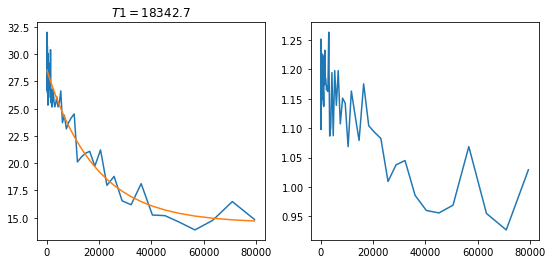

In [22]:
t_T1, q_target = np.logspace(0,4.9,101,endpoint=True), q1
await psg_ex1.setValue('Moutput','OFF')
job = Job(mr.T1, (q_target,measure,t_T1,(len(t_T1)-1),True), tags=[tag], max=500,avg=True)
t_t, s_t = await job.done()
A, B, T1 = op.Exp_Fit().fitExp(t_t[:,0],np.abs(s_t[:,0]))
z = A * np.exp(-t_t[:,0]/T1) + B
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_t,np.abs(s_t))
axes[0].plot(t_t[:,0],z)
axes[0].set_title('$T1=%.1f$'%T1)
axes[1].plot(t_t,np.angle(s_t))
plt.show()

In [35]:
q1 = q1._replace(T1=T1)

In [67]:
q4

qubit(q_name='q4', inst={'dc': 'dc11', 'z_awg': 'awg131', 'z_ch': 4, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex2', 'com': 'com8'}, T_bias=[1.753, 0.176], specfunc=-199.359302124614*cos(0.0594068374593189*pi*x + 3.10601583645447) - 195.359697320355, bias=-0.15, zpulse=None, f_lo=array([6.54382e+09]), delta=array([50000000.]), f_ex=array([3.79e+09]), delta_ex=array([0]), power_ex=30, power_rabi=5, pi_len=13.04, T1=26511.572081147293, state=[{'dc01': {'offset': 0.0, 'load': 'high Z'}, 'dc02': {'offset': 0.0, 'load': 'high Z'}, 'dc03': {'offset': 0.067, 'load': 'high Z'}, 'dc05': {'offset': 0.0, 'load': 'high Z'}, 'dc06': {'offset': 1.1035, 'load': 'high Z'}, 'dc07': {'offset': 0.0, 'load': 'high Z'}, 'dc08': {'offset': 0.0, 'load': 'high Z'}, 'dc10': {'offset': 0.0, 'load': 'high Z'}, 'dc11': {'offset': 0.1, 'load': 'high Z'}, 'dc15': {'offset': 0.9695, 'load': 'high Z'}, 'dc20': {'offset': 0.0, 'load': 'high Z'}, 'psg_lo': {'freq': '6.594040GHz', 'power': '13.000000dBm', 'outp

# Ramsey

In [25]:
t_Ramsey, q_target = np.linspace(0,5000,201), q7
# if q_target.inst['ex_lo'] == 'psg_ex2':
# measure.delta,measure.base,measure.readlen = q_target.state[1:]
# await mr.RecoverInst(measure,state=q_target.state[0])
await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex+3e6)[0])

Output()

(24.749133244278916, 44.384853502005775, 20000, 1510.511371246023, 0.0028000000000000004, 0)


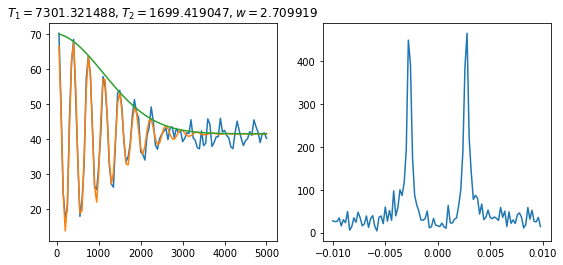

In [26]:
# %matplotlib notebook
await psg_ex1.setValue('Moutput','ON')
# mr.Att_Setup(q_target.inst['com']).Att(q_target.power_rabi)
#await psg[q_target.inst['ex_lo']].setValue('Power',q_target.power_rabi)
job = Job(mr.Ramsey, (q_target,measure,t_Ramsey,(len(t_Ramsey)-1),True), tags=[tag], max=500,avg=True)
t_ram, s_ram = await job.done()
x, y = t_ram[:,0], s_ram[:,0]
A,B,T1,T2,w,phi = op.T2_Fit(T1=20000,funcname='gauss',envelopemethod='hilbert').fitT2(x,np.abs(y))
z = A*np.exp(-(x/T2)**2-x/T1/2)*np.cos(2*np.pi*w*x+phi) + B
z_env = A*np.exp(-(x/T2)**2-x/T1/2) + B
sample = (np.max(x) - np.min(x))/(len(x) - 1)
yt  = np.fft.fftshift(np.fft.fftfreq(len(y))) / sample
amp = np.fft.fftshift(np.fft.fft(y))
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_ram,np.abs(s_ram))
axes[0].plot(x,z)
axes[0].plot(x,z_env)
axes[0].set_title('$T_{1}=%f,T_{2}=%f,w=%f$'%(T1,T2,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

In [408]:
4.54214-4.18204

0.3601000000000001

In [409]:
4.18204-3.68342

0.49861999999999984

<IPython.core.display.Javascript object>


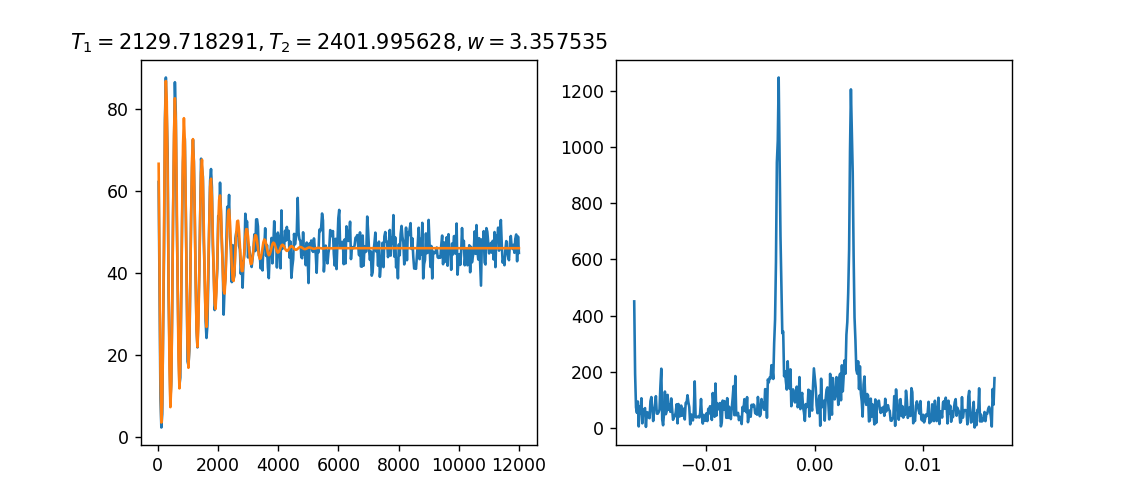

In [303]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(t_ram,np.abs(s_ram))
axes[0].plot(x,z)
# axes[0].plot(x,z_env)
axes[0].set_title('$T_{1}=%f,T_{2}=%f,w=%f$'%(T1,T2,w*1e3))
axes[1].plot(yt[yt!=0],np.abs(amp[yt!=0]))
plt.show()

<IPython.core.display.Javascript object>


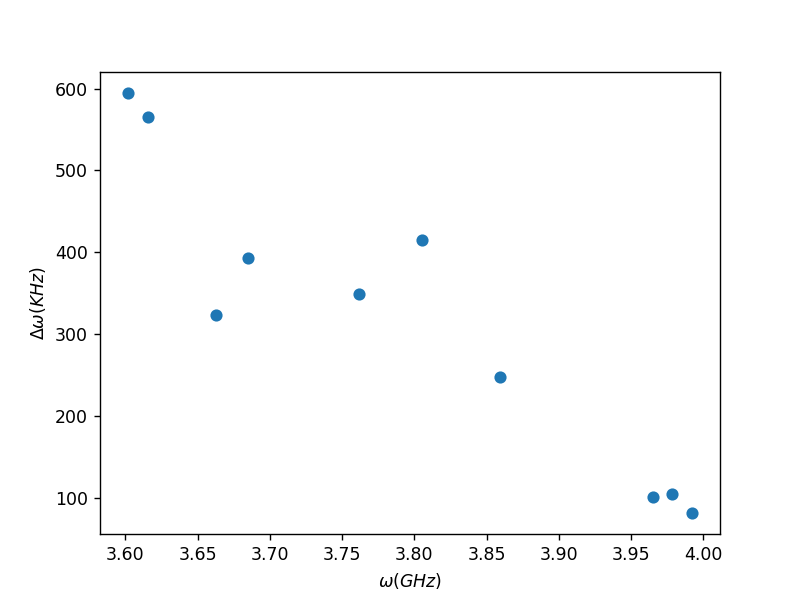

In [410]:
f = np.array([3.805,3.978,3.602,3.762,3.992,3.859,3.616,3.965,3.685,3.663])
df = np.array([0.41499,0.10439,0.59453,0.34952,0.08163,0.24785,0.56559,0.10131,0.39304,0.32317])*1e3
f_center = np.array([3.37939,3.29674,2.20569,2.98343,3.16597,2.8314,5.49745,4.77655,4.18204])*1e3
plt.figure()
plt.plot(f,df,'o')
plt.ylabel('$\Delta \omega(KHz)$')
plt.xlabel('$\omega (GHz)$')
plt.show()

In [244]:
f = await  psg[q_target.inst['ex_lo']].getValue('Frequency')
await psg[q_target.inst['ex_lo']].setValue('Frequency',(f-w*1e9+3e6))

In [31]:
q3

qubit(q_name='q3', inst={'dc': 'dc06', 'z_awg': 'awg131', 'z_ch': 3, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex2', 'com': 'com8'}, T_bias=[1.759, 0.224], specfunc=0.131407814121408 - 3.8786690306747*cos(0.434829499349968*pi*x + 2.8383237533104), bias=-0.1, zpulse=None, f_lo=array([6.53064e+09]), delta=array([50000000.]), f_ex=array([3.805e+09]), delta_ex=array([0]), power_ex=30, power_rabi=13, pi_len=23.498, T1=23016.178849233776, state=[{'dc01': {'offset': 1.168, 'load': 'high Z'}, 'dc02': {'offset': 0.0, 'load': 'high Z'}, 'dc03': {'offset': 0.067, 'load': 'high Z'}, 'dc05': {'offset': 0.0, 'load': 'high Z'}, 'dc06': {'offset': -0.1, 'load': 'high Z'}, 'dc07': {'offset': 0.0, 'load': 'high Z'}, 'dc08': {'offset': 0.0, 'load': 'high Z'}, 'dc10': {'offset': 0.0, 'load': 'high Z'}, 'dc11': {'offset': 1.0525, 'load': 'high Z'}, 'dc15': {'offset': 0.0, 'load': 'high Z'}, 'dc20': {'offset': 0.0, 'load': 'high Z'}, 'psg_lo': {'freq': '6.580640GHz', 'power': '13.000000dBm', 'outpu

# CrossTalk矫正

In [362]:
t_rabi = np.linspace(0,100,201)
measure.wave['Read'] = [['Readout_I']*len(t_rabi),['Readout_Q']*len(t_rabi)]

In [363]:
bits = [q1,q2,q3,q4,q5,q6,q7]
z_crosstalk = np.ones((10,10))

q1
com8 open...
DS Instruments,DAT64H,391,V9.10
last ATT 13.0
now ATT 13.0


Output()

8.240706352572118 11.866319164078828 10.000000000000004 4.819510257874948


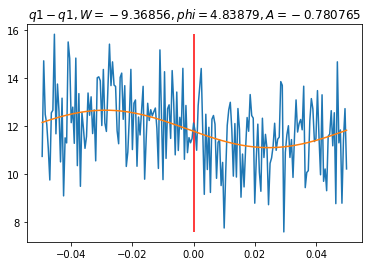

Output()

82.86512267259447 43.92212361265299 0.5 5.155693020408492


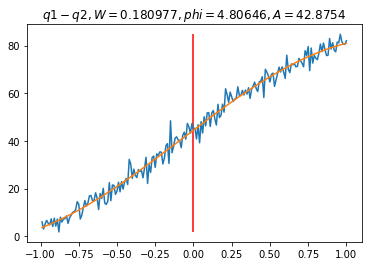

Output()

11.025154763428503 13.773250729507343 50.0 312.56888584357


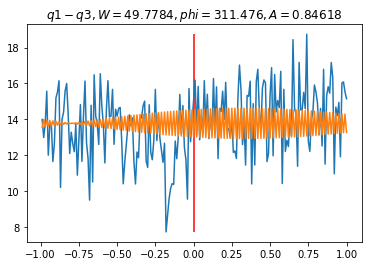

Output()

9.238886857670693 18.003522026626232 0.5 4.813812909556281


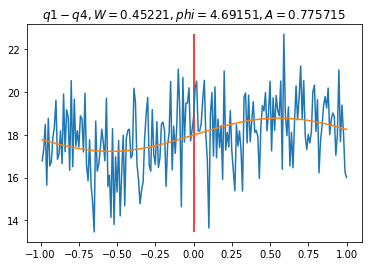

Output()

7.453434833543891 20.847103846131816 50.0 312.2798821565552


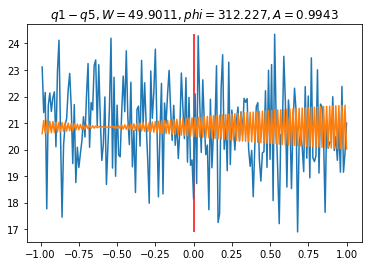

Output()

90.32214702274125 42.97568042922486 0.5 4.565425063645822


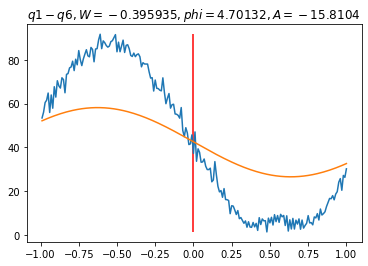

Output()

11.703061667863134 14.748198815477867 0.5 4.854701644165212


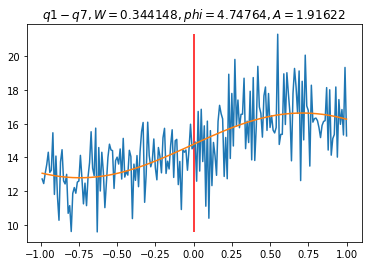

q2
com8 open...
DS Instruments,DAT64H,391,V9.10
last ATT 13.0
now ATT 13.0


Output()

20.219977541660224 15.34191365839486 0.5 4.732295577963399


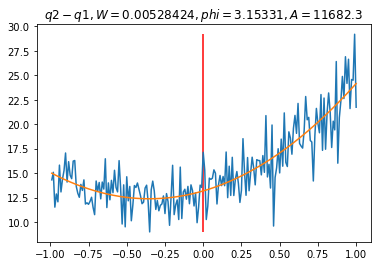

Output()

124.10454915550186 62.57258924499703 40.000000000000014 13.850026398354611


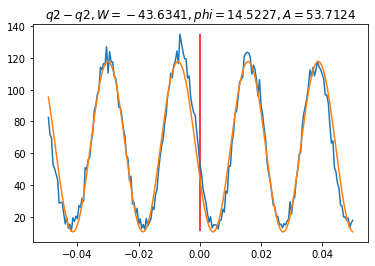

Output()

115.83154829901152 72.5620054480406 0.5 4.377818477840776


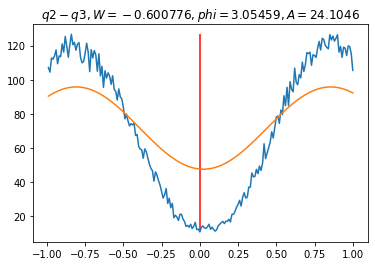

Output()

49.581700306866466 20.195739247081736 0.5 4.264943847310336


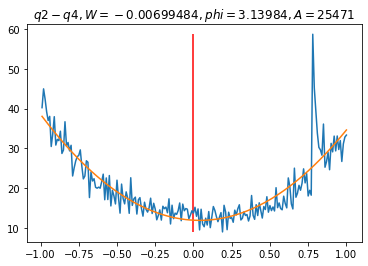

Output()

101.5169759257788 40.42591166751353 0.5 4.34003850621996


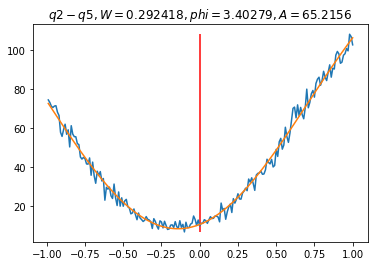

Output()

102.65853631210341 66.57486659881825 0.5 4.244115072935843


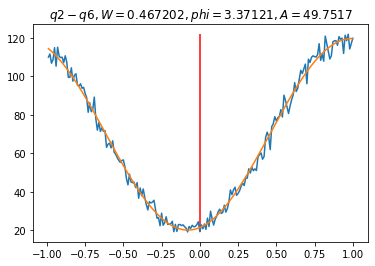

Output()

61.794300311741935 50.6678320423968 0.5 4.434714530781434


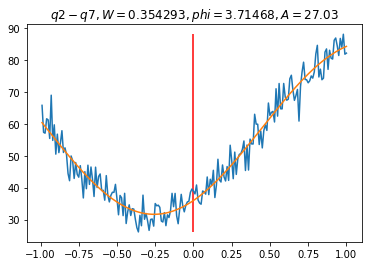

q3
com8 open...
DS Instruments,DAT64H,391,V9.10
last ATT 13.0
now ATT 13.0


Output()

20.501749570537754 55.20097210508955 2.5 17.036435754865735


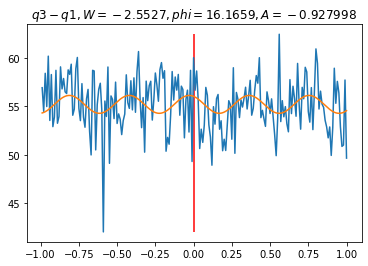

Output()

110.497055471419 77.42464695073572 1.5 10.712081852653473


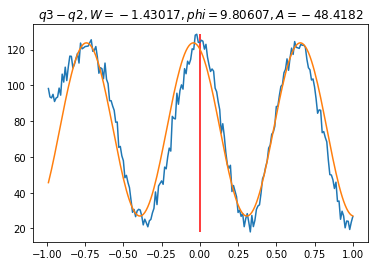

Output()

108.18913845702978 72.36097454650798 80.00000000000003 26.203001225572276


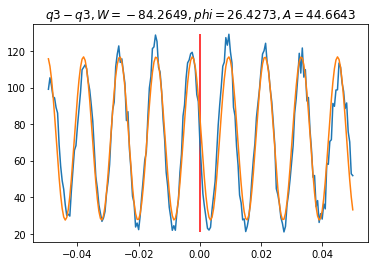

Output()

103.532612295886 70.9279042253005 1.5 11.34109755233214


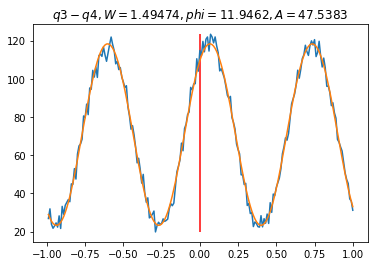

Output()

105.42170924180296 66.02070883427123 0.5 4.740551468591263


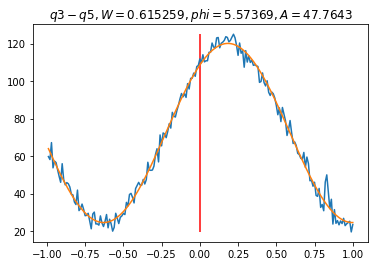

Output()

25.127094335124227 24.299309512300848 1.0 8.254752675255375


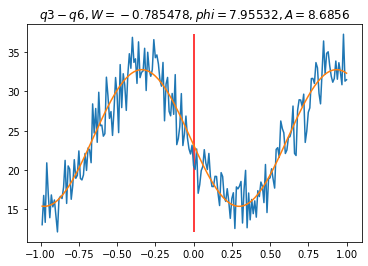

Output()

107.79286875729034 70.56670323382049 0.5 5.037018533254623


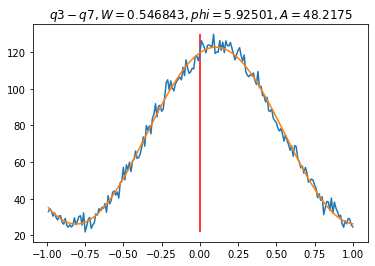

q4
com8 open...
DS Instruments,DAT64H,391,V9.10
last ATT 13.0
now ATT 13.0


Output()

42.40431132709341 84.92150923243878 0.5 5.248010747118331


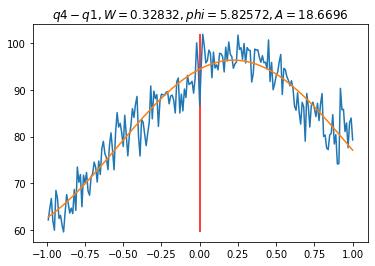

Output()

96.55001459311288 63.47230854061997 1.5 10.786629674280682


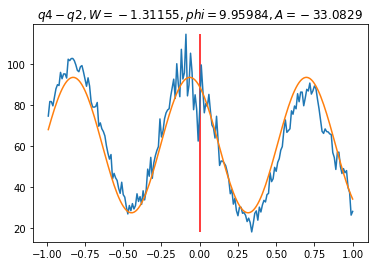

Output()

91.20812105205427 56.12309648880795 1.5 11.216799938827243


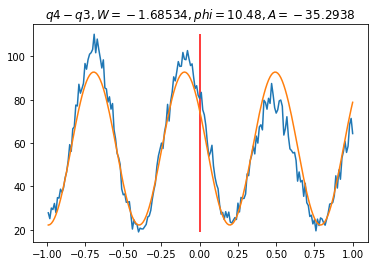

Output()

106.78990381296859 60.032116852861755 70.00000000000004 23.399405057446078


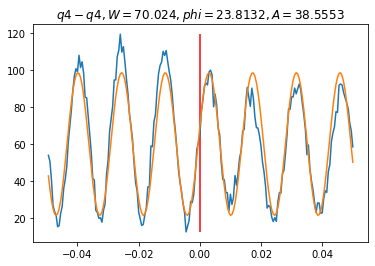

Output()

99.33353250699642 54.92270584505863 1.5 11.206867079114252


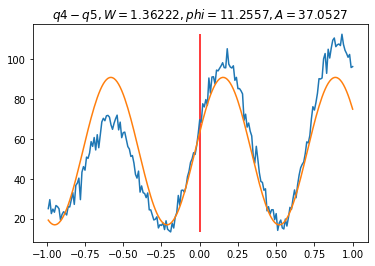

Output()

89.01892839161997 51.06392073878114 1.0 7.6661394164744


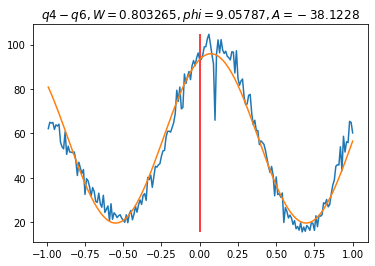

Output()

94.93033504088825 53.257469636002845 0.5 4.943359836309389


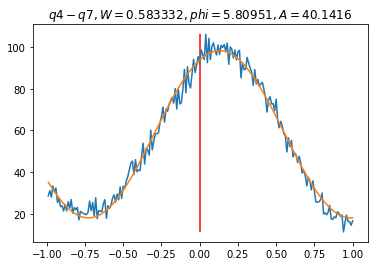

q5
com8 open...
DS Instruments,DAT64H,391,V9.10
last ATT 13.0
now ATT 13.0


Output()

16.174194256789107 88.34163793605144 50.0 312.7629603254601


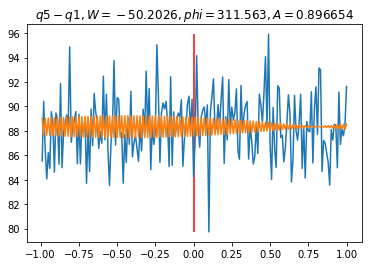

Output()

60.401664995962854 69.6997098868638 1.0 7.507407281911274


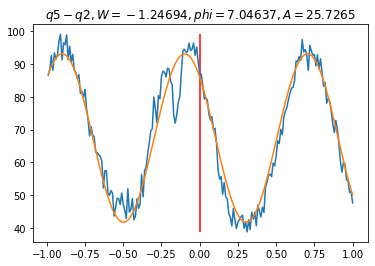

Output()

71.50412386367795 63.60290630140104 1.0 7.4923721453857715


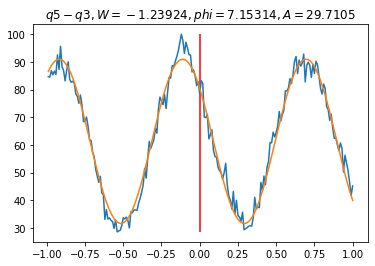

Output()

71.24713799720918 66.33046506862475 1.5 10.600275829060314


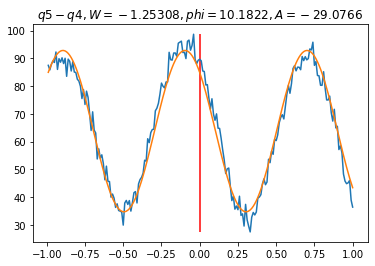

Output()

34.36746459373377 50.57788266296442 90.00000000000003 29.74244820116202


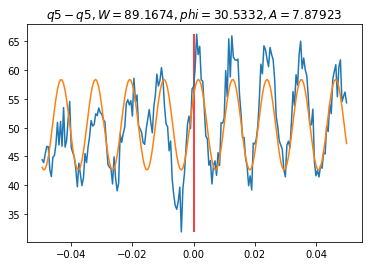

Output()

76.2000278019548 60.07409926370889 1.5 10.904884870655206


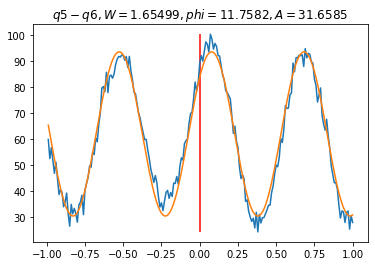

Output()

69.20804425163904 62.66358096146253 0.5 4.412734121521064


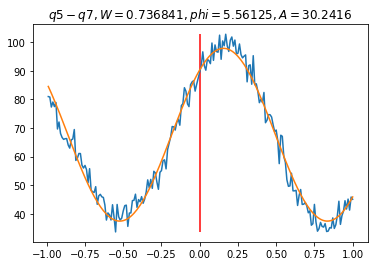

q6
com8 open...
DS Instruments,DAT64H,391,V9.10
last ATT 13.0
now ATT 13.0


Output()

50.29902314383659 29.2723178137625 0.5 4.186658268811408


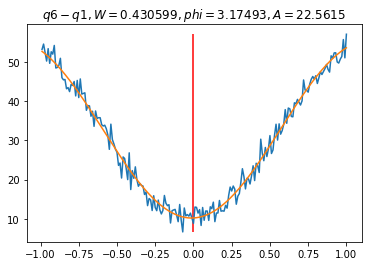

Output()

51.28685052270999 31.773505488683604 1.5 10.67536856268521


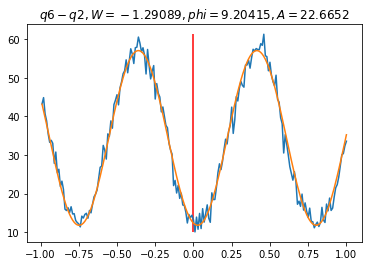

Output()

50.66862004959802 31.26814976316582 1.5 10.618297712022057


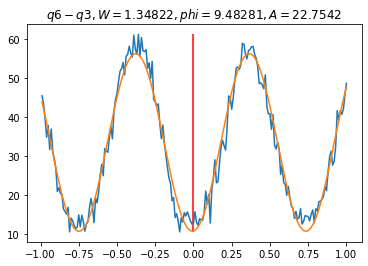

Output()

57.25048961672298 28.992769530382184 1.0 8.174038584224522


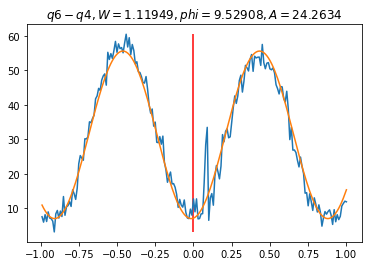

Output()

57.68317462675519 29.70642522330934 2.0 14.386680899603542


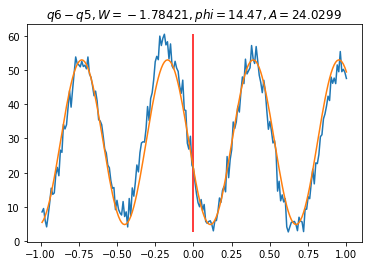

Output()

59.15932958289778 31.526887248032597 90.00000000000003 29.385364283722815


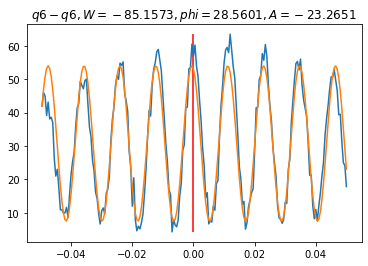

Output()

60.380895332998044 31.56373177450354 1.0 8.309419299090827


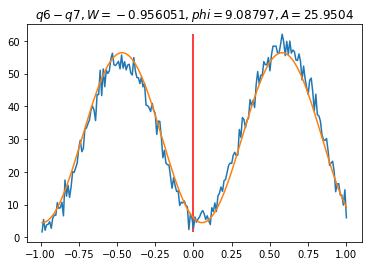

q7
com8 open...
DS Instruments,DAT64H,391,V9.10
last ATT 13.0
now ATT 13.0


Output()

12.151549931959302 45.91995780067486 0.5 4.852545070236435


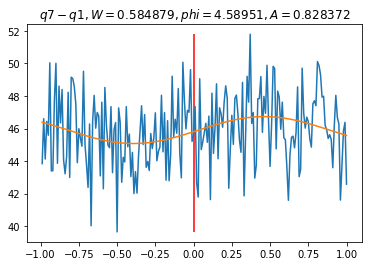

Output()

52.33685464359038 28.159879481306017 1.0 7.33849526312865


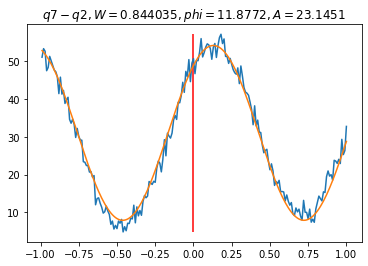

Output()

52.27958821959752 30.20161970601911 1.0 7.355917177584529


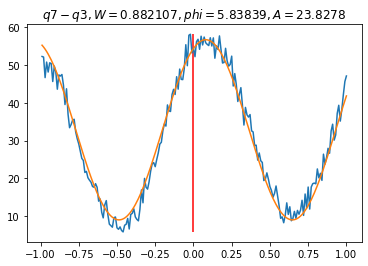

Output()

54.76153755451361 28.633652769000783 0.5 4.5008246937920635


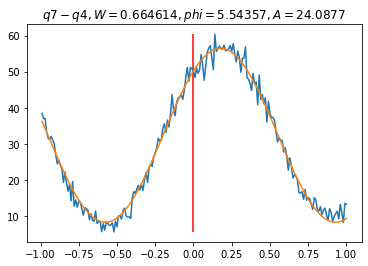

Output()

52.50560899440714 32.83180385754118 1.0 7.3330905536226805


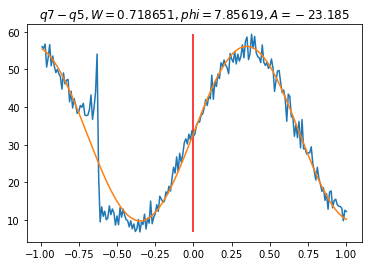

Output()

48.86810002770622 24.56888364510186 1.5 11.004069237866934


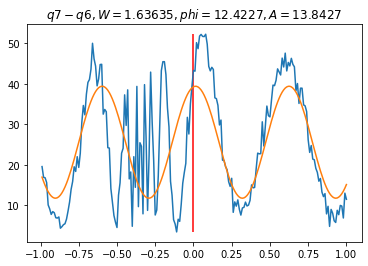

Output()

58.16906800970034 29.6377360782004 60.00000000000002 20.60093467246861


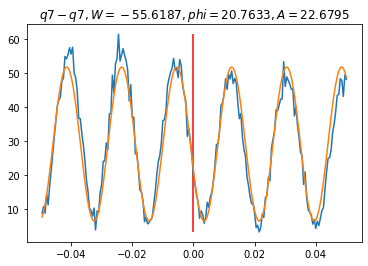

In [364]:
# fig, axes = plt.subplots(ncols=7,nrows=7,figsize=(28,28))
%matplotlib inline
await mr.jpa_switch(measure,'ON')
for v,k in enumerate(bits,start=0):
    q_target = k
    print(q_target.q_name)
    measure.delta,measure.base,measure.readlen = q_target.state[1:]
    await mr.RecoverInst(measure,state=q_target.state[0])
    mr.Att_Setup(q_target.inst['com']).Att(q_target.power_rabi)
    for i,j in enumerate(bits):
        q_bias = j
        tag = q_target.q_name + '_' + q_bias.q_name
        if q_bias == q_target:
            if q_target.f_ex[0] > 3.9e9:
                v_rabi = np.linspace(-0.5,0.5,201)
            else:
                v_rabi = np.linspace(-0.05,0.05,201)
        else:
            v_rabi = np.linspace(-1,1,201)
        job = Job(mr.Z_cross, (q_target,q_bias,measure,v_rabi,(len(v_rabi)-1),True), tags=[tag], max=500,avg=True)
        v_Z, s_Z = await job.done()
#         await awg131.use_waveform(name='test',ch=i+1)
        await mr.InitInst(measure,psgdc=False,awgch=True)
        try:
            A, C, W, phi = op.Cos_Fit().fitCos(v_Z[:,0], np.abs(s_Z[:,0]))
        except Exception or RuntimeWarning:
            print('bad fitting')
            A, C, W, phi =0,0,0,0
        z = A*np.cos(2*np.pi*W*v_Z+phi)+C
        v_op = op.RowToRipe().firstMax(v_Z[:,0],np.abs(z[:,0]),num=0)
        W = -W if v_op < 0 else W
        z_crosstalk[v,i] = W
        plt.figure()
        plt.plot(v_Z,abs(s_Z))
        plt.plot(v_Z,z)
        plt.vlines(0,np.max(np.abs(s_Z[:,0])),np.min(np.abs(s_Z[:,0])),'r')
        plt.title(r'$%s-%s,W = %g,phi=%g,A=%g $' %(q_target.q_name,q_bias.q_name,W,phi,A))
        plt.show()
    await mr.InitInst(measure,psgdc=True,awgch=True)


In [24]:
z_crosstalk

NameError: name 'z_crosstalk' is not defined

# 普矫正

In [24]:
v_rabi = np.linspace(-0.05,0.05,101)
await measure.awg['awgread'].remove_sequence(name='Read')
measure.wave['Read'] = [['Readout_I']*len(v_rabi),['Readout_Q']*len(v_rabi)]

In [ ]:
bits = [q2,q3,q4,q5,q6,q7]
for v, k in enumerate(bits[2:3]):
    q_target = k
    measure.delta,measure.base,measure.readlen = q_target.state[1:]
    await mr.RecoverInst(measure,state=q_target.state[0])
    mr.Att_Setup(q_target.inst['com']).Att(q_target.power_ex)
    await psg[q_target.inst['ex_lo']].setValue('Frequency',(q_target.f_ex+q_target.delta_ex)[0])
    for i,j in enumerate(bits[4:6]):
        q_bias = j
        if q_bias == q_target:
            continue
        else:
            tag = q_target.q_name + '_' + q_bias.q_name
            print(tag)
            job = Job(mr.crosstalkSpec, (q_target,q_bias,measure,v_rabi,(len(v_rabi)-1),True), tags=[tag], max=11)
            v_ex, v_bias, s_sc = await job.done()
            await mr.InitInst(measure,psgdc=False,awgch=True)
    await mr.InitInst(measure,psgdc=True,awgch=True)

com8 open...
DS Instruments,DAT64H,391,V9.10
last ATT 30.0
now ATT 30.0
q4_q6


Output()

q4_q7


Output()

In [9]:
measure.n = 1

# 二维谱

In [127]:
freq = np.arange(3.45,4.05,0.001)*1e9
bits = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10]
for i in bits[5:]:
    att_setup = mr.Att_Setup(i.inst['com'])
    att_setup.Att(i.power_ex)
    await mr.jpa_switch(measure,'ON')
    await awg134.output_on(ch=7)
    await awg134.output_on(ch=8)
    print(i.q_name)
    qubits = mr.qubitCollections(bits,q_target=i.q_name)
    job = Job(mr.spec2d, (qubits,measure,freq,True), tags=[i.q_name], max=31)
    v_s2, f_s2, s_s2 = await job.done()
    await mr.InitInst(measure,psgdc=True,awgch=True,clearwaveseq=None)

com4 open...
DS Instruments,DAT64H,375,V9.10
last ATT 25.0
now ATT 60.0
q6


Output()

com8 open...
DS Instruments,DAT64H,391,V9.10
last ATT 30.0
now ATT 30.0
q7


Output()

com14 open...
DS Instruments,DAT64H,380,V9.10
last ATT 25.0
now ATT 60.0
q8


Output()

com8 open...
DS Instruments,DAT64H,391,V9.10
last ATT 30.0
now ATT 30.0
q9


Output()

com6 open...
DS Instruments,DAT64H,376,V9.10
last ATT 35.0
now ATT 60.0
q10


Output()

QuLabRPCTimeout: Time out.

In [121]:
q9

qubit(q_name='q9', inst={'dc': 'dc20', 'z_awg': 'awg134', 'z_ch': 2, 'ex_awg': 'awg132', 'ex_ch': [7, 8], 'ex_lo': 'psg_ex2', 'com': 'com8'}, T_bias=[1.723, 0.036], specfunc=39.6496463377481*cos(0.138448308989957*pi*x + 0.0379197938863011) - 35.4990001632686, bias=-0.379, zpulse=None, f_lo=[6605000000.0], delta=array([50000000.]), f_ex=array([3.768e+09]), delta_ex=array([0]), power_ex=40, power_rabi=None, pi_len=None, T1=None)

In [122]:
q9 = q9._replace(power_ex=30)

# RB 

In [ ]:
mlist, q_target, len_data = np.logspace(0.4,2.5,21,dtype=int), q1, 31
await measure.awg['awgread'].stop()
await measure.awg['awgread'].query('*OPC?')
await measure.awg['awgread'].remove_sequence(name='Read')
measure.wave['Read'] = [['Readout_I']*len_data,['Readout_Q']*len_data]

In [ ]:
job = Job(mr.RB, (q_target,measure,mlist,len_data,True), tags=[tag], max=len(mlist))
n_RB, s_RB = await job.done()

In [ ]:
pop = []
for j in range(np.shape(s_RB)[0]):
    s = np.array(s_RB[j])
    pm = []
    for i in range(np.shape(s)[1]):
        d = list(zip(np.real(s[:,i]),np.imag(s[:,i])))
        y = measure.predict(d)
        pm.append(list(y).count(0)/len(y))
    pop.append(pm)

In [ ]:
#n_RB = [1,5,10,20,50,100,150]
x = np.meshgrid(range(np.shape(pop)[1]),n_RB)[1]
%matplotlib notebook
plt.figure()
plt.plot(x.flatten(),np.array(pop).flatten(),'.')
plt.show()

In [ ]:
def err(paras,x,y):
    A,B,p = paras
    return A*p**x+B-y
def guess(x,y):
    B = np.min(y)
    y = y - np.min(y)
    mask = y > 0
    a = np.polyfit(x[mask], np.log(y[mask]), 1)
    return np.exp(np.abs(a[1])), B, 1/np.exp(np.abs(a[0]))

In [ ]:
x, y = n_RB, np.abs(np.mean(pop,axis=1))
p0 = guess(x,y)
res = ls(err, p0, args=(x, y)) 
A,B,p = res.x
fig = plt.gcf()
ax = plt.getp(fig,'axes')
z = A*p**x+B
ax[0].plot(x,z)
ax[0].plot(x,y,'o')
ax[0].set_title('p=%f'%p)
plt.show()

In [ ]:
i = 20
s = np.array(s_RB[0])
d = list(zip(np.real(s[:,i]),np.imag(s[:,i])))
y = measure.predict(d)
print(list(y).count(0)/len(y))
plt.figure()
plt.scatter(np.real(s[:,i]),np.imag(s[:,i]),c=y,s=10)
plt.show()

<IPython.core.display.Javascript object>


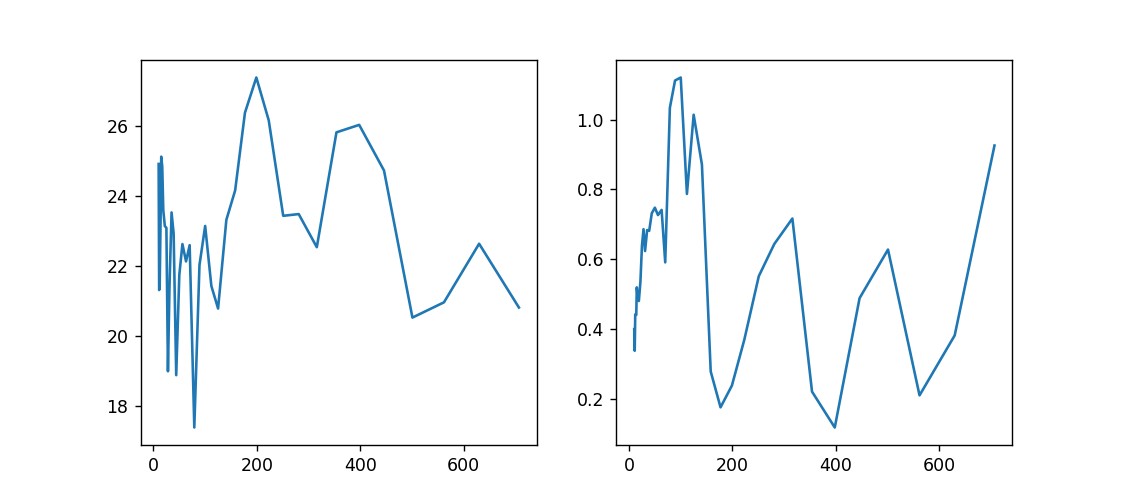

In [260]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(n_RB,np.abs(s_RB[:,:,0].mean(axis=1)))
axes[1].plot(n_RB,np.angle(s_RB[:,:,0].mean(axis=1)))
plt.show()

In [91]:
class qubitCollections():
    def __init__(self,qubits,calimatrix=None):
        self.qubits = {i.q_name:i for i in qubits}
        qstate = {}
        for i in self.qubits:
            qstate[i] = {'dc':0,'bias_z':0,'ex':0,'read':False}
        self.__setattr__('qstate',qstate)
        if calimatrix != None:
            self.calimatrix = calimatrix
    
    def readMixing(self,f_cavity):
        f_lo = f_cavity.max() + 50e6
        delta =  f_lo - f_cavity 
        n = len(f_cavity)
        return f_lo, delta, n

    def exMixing(self,f):
        qname = [i[0] for i in f]
        f_ex = np.array([i[1] for i in f])
        ex_lo = f_ex.mean() + 50e6
        delta =  ex_lo - f_ex
        delta_ex = {qname[i]:delta[i] for i in range(len(qname))}
        # n = len(f_ex)
        return ex_lo, delta_ex

    def qubitExecute(self,state=None):
#         if state != None:
#             for i in state:
#                 self.qstate[i] = state[i]
#         else:
#             pass
        #bias
        qall = {'dc':{},'awg131':{},'awg132':{},'awg133':{},'awg134':{},'awg_read':{}}
        bias, bias_z = [], []
        for i in self.qubits:
            if i in state and 'dc' in state[i]:
                bias.append(state[i]['dc'])
            else:
                bias.append(self.qstate[i]['dc'])
            if i in state and 'bias_z' in state[i]:
                bias_z.append(state[i]['bias_z'])
            else:
                bias_z.append(self.qstate[i]['bias_z'])
        if hasattr(self,'calimatrix'):
            bias_cross = np.mat(self.calimatrix).I * np.mat(bias).T
            self.bias_cross = bias_cross
            bias_cross_z = np.mat(self.calimatrix).I * np.mat(bias_z).T
            self.bias_cross_z = bias_cross_z
        else:
            self.bias_cross = np.array(bias)
            self.bias_cross_z = np.array(bias_z)
        #read
        fread = []
        for i in state:
            if 'read' in state[i] and state[i]['read']:
                fread.append(self.qubits[i].f_lo[0])
        f_lo, delta, n = self.readMixing(np.array(fread))
        self.f_lo, self.delta, self.n = f_lo, delta, n
        #excite
        fex1, fex2 = [], []
        for i in self.qubits:
            if i in state and 'ex' in state[i]:
                if self.qubits[i].inst['ex_lo'] == 'psg_ex1':
                    if state[i]['ex'] != 0:
                        fex1.append((i,self.qubits[i].f_ex[0]))
                if self.qubits[i].inst['ex_lo'] == 'psg_ex2':
                    if state[i]['ex'] != 0:
                        fex2.append((i,self.qubits[i].f_ex[0]))        

        qall['psg_lo'] = {'Frequency':self.f_lo}
        qall['awg_read']['ch'+str(7)] = [('Frequency',self.delta)]
        qall['awg_read']['ch'+str(8)] = [('Frequency',self.delta)]

        for i, j in enumerate(self.qubits):
            qall['dc'][self.qubits[j].inst['dc']] = self.bias_cross[i]
            qall[self.qubits[j].inst['z_awg']]['ch'+str(self.qubits[j].inst['z_ch'])] = [('Volt',self.bias_cross_z[i])]
            if fex1 != []:
                ex_lo1, delta_ex1 = self.exMixing(fex1)
                qall['psg_ex1'] = [('Frequency',ex_lo1)]
                if j in delta_ex1:
                    delta_ex = delta_ex1
                    for k in self.qubits[j].inst['ex_ch']:
                        qall[self.qubits[j].inst['ex_awg']]['ch'+str(k)] = [('Frequency',delta_ex[j])]
            if fex2 != []:
                ex_lo2, delta_ex2 = fex2[0][1], {fex2[0][0]:0}
                qall['psg_ex2'] = [('Frequency',ex_lo2)]
                if j in delta_ex2:
                    delta_ex = delta_ex2
                    for k in self.qubits[j].inst['ex_ch']:
                        qall[self.qubits[j].inst['ex_awg']]['ch'+str(k)] = [('Frequency',delta_ex[j])]
        self.qall = qall

In [92]:
qubits = qubitCollections([q1,q2])

In [93]:
qubits.qubitExecute(state={'q1':{'dc':0.1,'ex':1,'read':True},'q2':{'dc':0.2,'ex':1,'read':True}})

In [105]:
qubits.qall

{'dc': {'dc05': 0.1, 'dc01': 0.2},
 'awg131': {'ch1': [('Volt', 0)], 'ch2': [('Volt', 0)]},
 'awg132': {},
 'awg133': {'ch1': [('Frequency', 50000000.0)],
  'ch2': [('Frequency', 50000000.0)],
  'ch3': [('Frequency', 0)],
  'ch4': [('Frequency', 0)]},
 'awg134': {},
 'awg_read': {'ch7': [('Frequency', array([63040000., 50000000.]))],
  'ch8': [('Frequency', array([63040000., 50000000.]))]},
 'psg_lo': {'Frequency': 6567880000.0},
 'psg_ex1': [('Frequency', 3827663454.9989433)],
 'psg_ex2': [('Frequency', 3778344189.344115)]}

In [66]:
qubits.qstate

{'q1': {'dc': 0, 'bias_z': 0, 'ex': 0, 'read': False},
 'q2': {'dc': 0, 'bias_z': 0, 'ex': 0, 'read': False}}

In [95]:
q1

qubit(q_name='q1', inst={'dc': 'dc05', 'z_awg': 'awg131', 'z_ch': 1, 'ex_awg': 'awg133', 'ex_ch': [1, 2], 'ex_lo': 'psg_ex1', 'com': 'com11'}, T_bias=[2.021, 0.1], specfunc=3.18165278140929 - 0.749269561602177*cos(0.858616923290698*pi*x + 2.88505071245547), bias=-0.15, zpulse=None, f_lo=array([6.50484e+09]), delta=array([50000000.]), f_ex=array([3.77766345e+09]), delta_ex=array([80000000.]), power_ex=50, power_rabi=25, pi_len=28.0, T1=23016.178849233776)

In [97]:
x = {}
for i in x:
    print(x[i])